# Modelo SVM para predecir la presión (SVR)

In [43]:
from typing import Union, Tuple
from pathlib import Path
from pprint import pprint

import numpy as np
import pandas as pd

# Importar los estimadores y escaladores necesarios
from sklearn.base import BaseEstimator
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

# Importar GridSearchCV para realizar la búsqueda de hiperparámetros
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns

# Trackeo de experimentos
import mlflow
import dagshub

In [44]:
mlflow.sklearn.autolog()

In [45]:
help(mlflow.sklearn.autolog)

Help on function autolog in module mlflow.sklearn:

autolog(log_input_examples=False, log_model_signatures=True, log_models=True, log_datasets=True, disable=False, exclusive=False, disable_for_unsupported_versions=False, silent=False, max_tuning_runs=5, log_post_training_metrics=True, serialization_format='cloudpickle', registered_model_name=None, pos_label=None, extra_tags=None)
    .. Note:: Autologging is known to be compatible with the following package versions: ``0.24.1`` <= ``scikit-learn`` <= ``1.4.2``. Autologging may not succeed when used with package versions outside of this range.
    
    
    Enables (or disables) and configures autologging for scikit-learn estimators.
    
    **When is autologging performed?**
      Autologging is performed when you call:
    
      - ``estimator.fit()``
      - ``estimator.fit_predict()``
      - ``estimator.fit_transform()``
    
    **Logged information**
      **Parameters**
        - Parameters obtained by ``estimator.get_params(de

In [46]:
experiment_name = "SVR_hp_tune_1"
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='mlflow-artifacts:/d75e54b290234d69975af87f4d77e8b6', creation_time=1717296628555, experiment_id='6', last_update_time=1717296628555, lifecycle_stage='active', name='SVR_hp_tune_1', tags={}>

In [47]:
# Te dará un link para que te logees en dagshub
dagshub.init(repo_owner='guillermovc', repo_name='MLOps-grinding', mlflow=True)

Initialized MLflow to track repo "guillermovc/MLOps-grinding"

Repository guillermovc/MLOps-grinding initialized!

## Definir función para buscar hiperparámetros

In [48]:
# definimos la función que toma datos y devuelve los mejores parámetros

def search_params(
        estimator: BaseEstimator,
        params: dict,
        X: np.ndarray, 
        y: np.ndarray, 
        random: bool = False, 
        n_iter: int = 100,
    ) -> Tuple[BaseEstimator, dict]:
    # Definir los parámetros para GridSearchCV

    print(f"Los parámetros para probar en nuestras pipelines son:")
    pprint(params)

    # Creamos un pipeline con parámetros por defecto (serán sustituidos)
    pipeline = Pipeline([
        ('scaler', None),
        ('regressor', estimator())
    ])

    if random:
        search = RandomizedSearchCV(pipeline, params, cv=5, n_jobs=-1, 
                                    scoring='neg_mean_squared_error', verbose=1, n_iter=n_iter)
    else:
        search = GridSearchCV(pipeline, params, cv=5, n_jobs=-1, 
                              scoring='neg_mean_squared_error', verbose=1)

    search.fit(X, y)

    # Obtener los mejores hiperparámetros y el mejor modelo
    best_params = search.best_params_
    best_model = search.best_estimator_

    print(f"Los mejores parámetros de la busqueda: {best_params}")
    print(f"El mejor modelo de la busqueda: {best_model}")

    return best_model, best_params

## Cargar el DataFrame

In [49]:
# Definir la ruta de los datos
data_path: Path = Path(r"../data/processed")
if not data_path.exists():
    print(f"El path {data_path} no existe, favor de revisar.")

# Imprimir archivos en la carpeta de datos
pprint(list(data_path.glob("*")))

[PosixPath('../data/processed/datos_molienda_prueba.parquet'),
 PosixPath('../data/processed/df_model_no_outliers.parquet'),
 PosixPath('../data/processed/df_model_tidy.parquet')]


In [50]:
parquet_path = data_path / "df_model_tidy.parquet"

df = pd.read_parquet(parquet_path)
df.head(3)

,date,velocidad,potencia,rendimiento,ruido,p80,f80,per_solidos,wi,spi,imp_criticos,imp_estandares,jb,presion
0,2022-11-15 00:07:50,75.761029,39281.348296,65.653747,22.932414,64.260113,36.574719,71.583049,94.815049,54.50695,7.101110,65.598165,9.183127,87.199926
1,2022-11-15 00:08:00,75.761029,39850.320731,65.691489,22.932414,64.260113,36.555098,71.579590,94.815049,54.50695,7.191338,65.798205,9.180693,87.402467
2,2022-11-15 00:08:10,75.761029,39761.319456,65.783858,21.329909,64.260113,36.535478,71.585002,94.815049,54.50695,7.281566,65.998244,9.178803,87.492231


In [51]:
df.tail(3)

,date,velocidad,potencia,rendimiento,ruido,p80,f80,per_solidos,wi,spi,imp_criticos,imp_estandares,jb,presion
248615,2022-12-14 23:59:40,75.497677,40686.296989,71.458539,8.845677,26.446656,46.134072,77.327109,92.573475,38.54322,0.898244,32.434377,89.314536,89.181349
248616,2022-12-14 23:59:50,75.499274,40686.296989,71.513813,8.845677,26.446656,46.336617,77.356121,92.573475,38.54322,0.896897,32.574649,89.314536,89.181349
248617,2022-12-15 00:00:00,75.499274,40594.117098,71.512283,9.922163,26.446656,46.590890,77.381390,92.573475,38.54322,0.904977,32.674668,89.310092,89.311585


## Definir `X` y `y`

In [52]:
X: np.ndarray = df.drop(columns=["presion", "date"]).to_numpy()
y: np.ndarray = df["presion"].to_numpy()

# Verificar tipos
print(f"{type(X) = }")
print(f"{type(y) = }")

# Verificar formas
print(f"{X.shape = }")
print(f"{y.shape = }")

type(X) = <class 'numpy.ndarray'>
type(y) = <class 'numpy.ndarray'>
X.shape = (248618, 12)
y.shape = (248618,)


# Separar en entrenamiento y prueba

Debido a que nuestro approach fue convertir de una serie de tiempo a un intervalo de 8 minutos, reservaremos primero los últimos días para probar el modelo.

In [53]:
# Tomar como prueba los datos desde el 12 de diciembre
date = "2022-12-12"

# Trackear desde que fecha tomaremos para testear
mlflow.log_param("test_start", date)

df[df["date"] > date]

,date,velocidad,potencia,rendimiento,ruido,p80,f80,per_solidos,wi,spi,imp_criticos,imp_estandares,jb,presion
223268,2022-12-12 00:00:10,61.231838,32730.218758,45.510341,3.604423,30.482594,29.060758,74.104980,96.306752,40.677938,0.000000,8.332114,86.330692,87.412911
223269,2022-12-12 00:00:20,61.164822,31598.631123,45.475115,3.791207,30.482594,29.061834,74.140991,96.306752,40.677938,0.000000,8.282104,86.327785,87.228387
223270,2022-12-12 00:00:30,61.097805,31541.416018,45.407662,3.791207,30.482594,29.062910,74.177002,96.306752,40.677938,0.000000,8.232094,86.326418,86.801345
223271,2022-12-12 00:00:40,61.030789,32142.174622,45.358609,3.791207,30.482594,29.074935,74.213013,96.306752,40.677938,0.000000,8.182084,86.325211,86.303138
223272,2022-12-12 00:00:50,60.963772,32142.174622,45.345342,3.791207,30.482594,29.040282,74.246053,96.306752,40.677938,0.000000,8.132075,86.323845,86.186404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248613,2022-12-14 23:59:20,75.494482,41194.875702,71.307249,8.845677,26.446656,45.849870,77.265464,92.573475,38.543220,0.900937,32.153835,89.318678,89.175128
248614,2022-12-14 23:59:30,75.496079,41194.875702,71.403265,8.845677,26.446656,45.931528,77.298097,92.573475,38.543220,0.899591,32.294106,89.318678,89.175128
248615,2022-12-14 23:59:40,75.497677,40686.296989,71.458539,8.845677,26.446656,46.134072,77.327109,92.573475,38.543220,0.898244,32.434377,89.314536,89.181349
248616,2022-12-14 23:59:50,75.499274,40686.296989,71.513813,8.845677,26.446656,46.336617,77.356121,92.573475,38.543220,0.896897,32.574649,89.314536,89.181349


In [54]:
df[df["date"] > date].shape[0]*100/df.shape[0]

10.19636550853116

Tomar los datos desde el 12 de diciembre representa un 10%

In [55]:
indice_sep = df[df["date"] > date].index[0]
print(f"{indice_sep = }")

indice_sep = 223268


In [56]:
X_train = X[:indice_sep]
y_train = y[:indice_sep]

X_test = X[indice_sep:]
y_test = y[indice_sep:]

print(f"{X_train.shape = }")
print(f"{X_test.shape = }")
print(f"{y_train.shape = }")
print(f"{y_test.shape = }")

X_train.shape = (223268, 12)
X_test.shape = (25350, 12)
y_train.shape = (223268,)
y_test.shape = (25350,)


## Tomar una pequeña muestra para búsqueda de hiperparámetros

In [57]:
# Ya que el entrenamiento es muy tardado, tomemos solo una parte de los datos
train_tune_size = 0.05
random_state = 1

# Trackear parámetro con mlflow
mlflow.log_param("train_tune_size", train_tune_size)
mlflow.log_param("random_state", random_state)

X_train_tune, _, y_train_tune, _ = train_test_split(X, y, train_size=train_tune_size, random_state=random_state)
print(f"Se usarán {X_train_tune.shape[0]:,} entradas para la búsqueda de hiperparámetros del modelo usando 5 folds)")

Se usarán 12,430 entradas para la búsqueda de hiperparámetros del modelo usando 5 folds)


In [58]:
X_train[0], y_train[0]

(array([7.57610289e+01, 3.92813483e+04, 6.56537472e+01, 2.29324136e+01,
        6.42601135e+01, 3.65747190e+01, 7.15830485e+01, 9.48150489e+01,
        5.45069496e+01, 7.10110967e+00, 6.55981655e+01, 9.18312691e+00]),
 87.19992569135509)

In [59]:
X_train_tune[0], y_train_tune

(array([7.57466521e+01, 4.20626381e+04, 6.13650391e+01, 1.39583069e+01,
        4.14472955e+01, 6.56300386e+01, 7.07733160e+01, 9.45722969e+01,
        4.71730256e+01, 4.45620556e+00, 6.17571721e+01, 1.02498835e+01]),
 array([91.26767223, 92.94189947, 89.33333426, ..., 89.88407426,
        88.62203393, 92.13461282]))

## Buscar hiperparámetros

In [71]:
with mlflow.start_run(nested=True, run_name="SVR_hp_tune_1"):
    # NOTA: para los parámetros del regresor se utiliza el prefijo regressor__ por convención
    # para indicar que ese parámetro es para el valor de la clave 'regressor'
    parameters = [
        {
            'scaler': [RobustScaler(), StandardScaler(), MinMaxScaler()],
            # Parámetros del clasificador
            'regressor__C': np.linspace(1, 100, 10),
            'regressor__kernel': ['linear', 'rbf', 'poly'],
            'regressor__gamma': ['scale', 'auto'],
        },
    ]

    tune_n_iters = 2
    tune_random = True

    mlflow.log_param("tune_n_iters", tune_n_iters)
    mlflow.log_param("tune_random", tune_random)

    best_model, best_params = search_params(
        SVR, parameters, X_train_tune, y_train_tune, n_iter=tune_n_iters, random=tune_random,
        )
    
    mlflow.log_params(best_params)

Los parámetros para probar en nuestras pipelines son:
[{'regressor__C': array([  1.,  12.,  23.,  34.,  45.,  56.,  67.,  78.,  89., 100.]),
  'regressor__gamma': ['scale', 'auto'],
  'regressor__kernel': ['linear', 'rbf', 'poly'],
  'scaler': [RobustScaler(), StandardScaler(), MinMaxScaler()]}]
Fitting 5 folds for each of 2 candidates, totalling 10 fits


2024/06/02 03:23:37 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


Los mejores parámetros de la busqueda: {'scaler': MinMaxScaler(), 'regressor__kernel': 'rbf', 'regressor__gamma': 'scale', 'regressor__C': 12.0}
El mejor modelo de la busqueda: Pipeline(steps=[('scaler', MinMaxScaler()), ('regressor', SVR(C=12.0))])


# Entrenar el modelo con todos los datos

In [61]:
# best_model.fit(X_train, y_train)

# Guardar el modelo


In [72]:
import joblib

model_filename = '../models/best_svr.pkl'

In [73]:
joblib.dump(best_model, model_filename)
print(f"Modelo guardado en {model_filename}")

Modelo guardado en ../models/best_svr.pkl


In [74]:
# Cargar el modelo desde el archivo
loaded_model = joblib.load(model_filename)
print(f"Modelo cargado: {loaded_model}")

Modelo cargado: Pipeline(steps=[('scaler', MinMaxScaler()), ('regressor', SVR(C=12.0))])


In [75]:
y_pred = loaded_model.predict(X_test)

mae = MAE(y_test, y_pred)
mse = MSE(y_test, y_pred)

In [76]:
print(f"MAE: {mae:,.4f}")
print(f"MSE: {mse:,.4f}")

MAE: 0.9833
MSE: 1.7714


In [77]:
mlflow.log_metrics(
    {
        "best_mse": mse,
        "best_mae": mae,
    }
)

# Graficar `y_true` vs `y_pred`

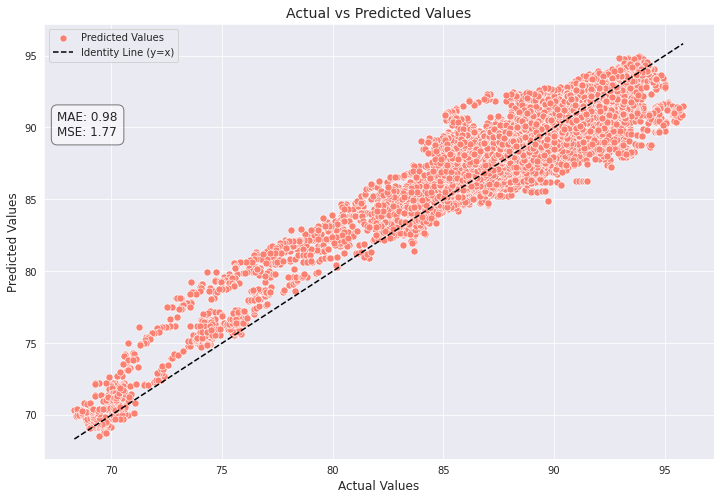

In [78]:
sns.set_style("darkgrid")

# Crear la figura y los ejes
plt.figure(figsize=(12, 8))

# Ploteo de valores reales vs predichos con seaborn
sns.scatterplot(x=y_test, y=y_pred, color='salmon', s=50, label='Predicted Values')

# Ploteo de la línea de identidad (y = x)
max_val = max(max(y_test), max(y_pred))
min_val = min(min(y_test), min(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], '--', color='black', label='Identity Line (y=x)')

# Añadir recuadro con MAE y MSE
textstr = f'MAE: {mae:.2f}\nMSE: {mse:.2f}'
# Propiedades del recuadro
props = dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='black', alpha=0.5)
# Ubicación del recuadro
plt.text(0.02, 0.8, textstr, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=props)

# Añadir títulos y etiquetas
plt.title('Actual vs Predicted Values', fontsize=14)
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.legend()
plt.grid(True)

plt.savefig("actual_vs_predicted_final.png")
mlflow.log_artifact("actual_vs_predicted_final.png")

# Mostrar el gráfico
plt.show()

In [79]:
from mlflow.models import infer_signature

# Infer the model signature
signature = infer_signature(X_test, y_pred)

mlflow.sklearn.log_model(
    sk_model=best_model,
    artifact_path="best_svr",
    signature=signature,
    registered_model_name="sk-learn-svr-model",
)

Registered model 'sk-learn-svr-model' already exists. Creating a new version of this model...
2024/06/02 03:25:25 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: sk-learn-svr-model, version 4
Created version '4' of model 'sk-learn-svr-model'.


In [82]:
df.head()

,date,velocidad,potencia,rendimiento,ruido,p80,f80,per_solidos,wi,spi,imp_criticos,imp_estandares,jb,presion
0,2022-11-15 00:07:50,75.761029,39281.348296,65.653747,22.932414,64.260113,36.574719,71.583049,94.815049,54.50695,7.101110,65.598165,9.183127,87.199926
1,2022-11-15 00:08:00,75.761029,39850.320731,65.691489,22.932414,64.260113,36.555098,71.579590,94.815049,54.50695,7.191338,65.798205,9.180693,87.402467
2,2022-11-15 00:08:10,75.761029,39761.319456,65.783858,21.329909,64.260113,36.535478,71.585002,94.815049,54.50695,7.281566,65.998244,9.178803,87.492231
3,2022-11-15 00:08:20,75.761029,39761.319456,65.906084,21.329909,64.260113,36.515857,71.598714,94.815049,54.50695,7.371795,66.198283,9.178803,87.492231
4,2022-11-15 00:08:30,75.761029,39665.960948,65.986245,22.538648,64.260113,36.583533,71.615886,94.815049,54.50695,7.462023,66.398322,9.174560,87.564041


In [80]:
mlflow.end_run()